<a href="https://colab.research.google.com/github/pikulsomesh/tutorials/blob/master/Demo_Colab_Tutorial_CPP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget -c https://repo.continuum.io/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh
!chmod +x Miniconda3-py37_4.8.3-Linux-x86_64.sh
!time bash ./Miniconda3-py37_4.8.3-Linux-x86_64.sh -b -f -p /usr/local
!time conda install -q -y -c conda-forge rdkit
!pip install textdistance
!git clone https://github.com/learningmatter-mit/peptimizer

import os
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

In [ ]:
cd peptimizer

In [ ]:
import os 
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

from utils.utils_cpp import cpp_predictor
from utils.utils_cpp import cpp_generator
from utils.utils_cpp import cpp_optimizer
from utils.utils_common.activator import Activation

#### Filepaths

*_DATA_PATH : For datasets, to be used when training and sampling <br>
*_MODEL_PATH : For models, to be used when training to save the model, otherwise to load pre-trained models <br>
PREDICTOR_STATS_PATH : To save/load statistics for predictor training dataset <br>

SEQ_MAX : Maximum sequence length for predictor <br>
SEED_SEQ_LENGTH : Seed sequence length for generator <br>

SMILES_PATH : SMILES for monomers <br>
FP_RADIUS : Radius of topological exploration for fingerprint <br>
FP_BITS : Size of fingerprint bit-vector

In [ ]:
# Upload 'cpp_predictor.hdf5' to 'peptimizer/model/model_cpp/'

GENERATOR_DATA_PATH = './dataset/data_cpp/cpp_generator_dataset.txt'
GENERATOR_MODEL_PATH = './model/model_cpp/cpp_generator.hdf5'
SEED_SEQ_LENGTH = 10

PREDICTOR_DATA_PATH = './dataset/data_cpp/cpp_predictor_dataset.csv'
PREDICTOR_MODEL_PATH = './model/model_cpp/cpp_predictor.hdf5'
PREDICTOR_STATS_PATH = './dataset/data_cpp/cpp_predictor_dataset_stats.json'

SMILES_PATH = './dataset/data_cpp/cpp_smiles.json'
FP_RADIUS = 3
FP_BITS = 1024
SEQ_MAX = 108

#### Generator

Creating an instance for Generator class with the dataset. <br>
Training and saving the generator

In [ ]:
generator = cpp_generator.Generator(data_path = GENERATOR_DATA_PATH, seq_length = SEED_SEQ_LENGTH)

generator.train_model()

Loading Data for Training of Generator
Pre-Processing Data for Generator
Featurizing Data for Generator
Starting Training of Generator
Train on 5987 samples, validate on 2567 samples
Epoch 1/2
5987/5987 [==============================] - 1s 155us/sample - loss: 2.8972 - accuracy: 0.1527 - val_loss: 2.6969 - val_accuracy: 0.1944
Epoch 2/2
5987/5987 [==============================] - 1s 119us/sample - loss: 2.6833 - accuracy: 0.1887 - val_loss: 2.6633 - val_accuracy: 0.1944


#### Predictor

Creating an instance for Predictor class with the dataset and other parameters. <br>
Training and saving the predictor

Loading Data for Training of Predictor
Featurizing Data for Predictor
Creating Model for Predictor
Train on 409 samples, validate on 103 samples
Epoch 1/2
409/409 [==============================] - 7s 17ms/sample - loss: 0.8561 - val_loss: 0.5336
Epoch 2/2
409/409 [==============================] - 7s 16ms/sample - loss: 0.4710 - val_loss: 0.3962


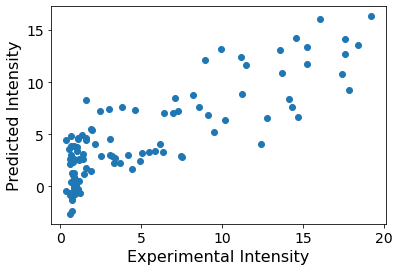

In [ ]:
predictor = cpp_predictor.Predictor(
    data_path = PREDICTOR_DATA_PATH,
    smiles_path = SMILES_PATH,
    fp_radius = FP_RADIUS,
    fp_bits = FP_BITS,
    seq_max = SEQ_MAX
)

predictor.train_model()

#### Optimizer

Creating an instance for Optimizer class with the pre-trained models and data files. <br>
Sampling sequences using a pre-trained generator to seed the genetic algorithm. <br>
Optimizing the seed sequences.

In [ ]:
optimizer = cpp_optimizer.Optimizer(
    model_path = PREDICTOR_MODEL_PATH,
    data_path = PREDICTOR_DATA_PATH,
    smiles_path = SMILES_PATH,
    stats_path = PREDICTOR_STATS_PATH,
    fp_radius = FP_RADIUS,
    fp_bits = FP_BITS,
    seq_max = SEQ_MAX
)

In [ ]:
generator = cpp_generator.Generator(
    model_path = GENERATOR_MODEL_PATH,
    data_path = GENERATOR_DATA_PATH,
    seq_length = SEED_SEQ_LENGTH
)

In [ ]:
list_seeds = generator.generate_seed(n_seeds = 2, seed_length = 30)

Generating Seeds for Optimizer
Generating Seed  1
Generating Seed  2


In [ ]:
df = optimizer.optimize(list_seeds)
df.head(2)

Setting up Optimizer
Optimizing Seed  1
Optimizing Seed  2
Post-Processing Optimized Sequences


,sequences,intensity,length,relative_Arg,relative_charge
265,GRPRESRKKRLGGCYKEAINGELPGHNXRXGXR,11.2325,34,0.176471,0.19862
264,GRPRESRKKRLGGCYKEAINGELAGHNXRXGXR,11.2119,34,0.176471,0.19862


#### Activation Analysis

Visualizing the gradient activation of peptide sequence (ex. penetratin) based on pre-trained predictor.

Positive activation for feature map


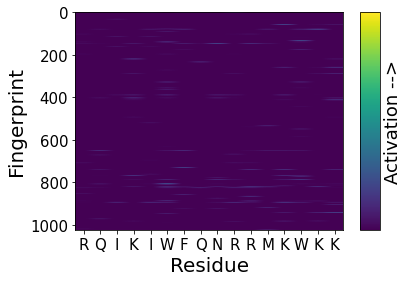

Positive activation averaged over residues


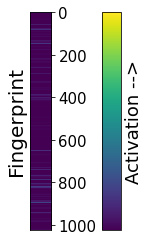

Positive activation averaged over fingerprints


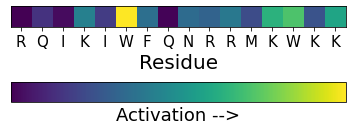

In [ ]:
activator = Activation(
    mode = 'cpp',
    model_path = PREDICTOR_MODEL_PATH,
    smiles_path = SMILES_PATH,
    stats_path = PREDICTOR_STATS_PATH,
    fp_radius = FP_RADIUS,
    fp_bits = FP_BITS,
    seq_max = SEQ_MAX
)

activator.analyze('RQIKIWFQNRRMKWKK')